In [14]:
import torch
import numpy as np
import triton
import triton.language as tl
import matplotlib
import pandas as pd


In [15]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    # x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)


In [ ]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 256, 'BLOCK_SIZE_E': 64, 'BLOCK_SIZE_K': 64}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 256, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 128, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 64, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 128, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_D': 32, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 32, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=2),
        triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_D': 64, 'BLOCK_SIZE_E': 32, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=2),
    ],
    key=['B', 'D', 'E'],
)
@triton.jit
def mlp_kernel(
    # Pointers to matrices
    x_ptr, w1_ptr, b1_ptr, w2_ptr, b2_ptr, z_ptr, o_ptr,
    # Matrix dimensions
    B, D: tl.constexpr, E,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_b1e,
    stride_w2e, stride_w2d,
    stride_b2d,
    stride_zb, stride_ze,
    stride_ob, stride_od,
    # Meta-parameters
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_D: tl.constexpr, BLOCK_SIZE_E: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the mlp
    Z = X @ W1 + b1, H = f(Z), O = H @ W2 + b2.
    - X has shape (B, D),
    - W1 has shape (D, E), b1 has shape (E)
    - W2 has shape (E, D), b2 has shape (D)
    - Z has shape (B, E), H has shape (B, E)
    - O has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid_b = tl.program_id(axis=0)
    pid_d = tl.program_id(axis=1)
    TARGET_TYPE = x_ptr.type.element_ty
    # ----------------------------------------------------------
    # a = tuple(1, )
    # tl.static_print('a', a)
    # a = tuple(a, )
    # tl.static_print('a', a)
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # x_ptrs = tl.make_block_ptr(
    #     base=x_ptr,
    #     shape=(B, D),
    #     strides=(stride_xb, stride_xd),
    #     offsets=(pid_b * BLOCK_SIZE_B, 0),
    #     block_shape=(BLOCK_SIZE_B, BLOCK_SIZE_K),
    #     order=(1, 0),
    # )
    # x = tl.load(x_ptrs)
    # NUM_HEADS: tl.constexpr = tl.cdiv(D, BLOCK_SIZE_K).to(tl.int32)
    # tl.static_print('NUM_HEADS', NUM_HEADS, NUM_HEADS.__dict__)
    # tl.static_print('x', x)
    # tl.static_print('(BLOCK_SIZE_B, NUM_HEADS, BLOCK_SIZE_K)', (BLOCK_SIZE_B, NUM_HEADS, BLOCK_SIZE_K))
    # x = tl.reshape(x, (BLOCK_SIZE_B, NUM_HEADS, BLOCK_SIZE_K))
    # x = x.permute(0, 2, 1).split()
    # tl.static_print('x', x)
    b1_ptrs = tl.make_block_ptr(
        base=b1_ptr,
        shape=(E,),
        strides=(stride_b1e,),
        offsets=(0,),
        block_shape=(BLOCK_SIZE_E,),
        order=(0,),
    )
    w2_ptrs = tl.make_block_ptr(
        base=w2_ptr,
        shape=(E, D),
        strides=(stride_w2e, stride_w2d),
        offsets=(0, pid_d * BLOCK_SIZE_D),
        block_shape=(BLOCK_SIZE_E, BLOCK_SIZE_D),
        order=(1, 0),
    )
    o = tl.zeros((BLOCK_SIZE_B, BLOCK_SIZE_D), dtype=tl.float32)
    for e in range(0, tl.cdiv(E, BLOCK_SIZE_E)):
        z = tl.zeros((BLOCK_SIZE_B, BLOCK_SIZE_E), dtype=tl.float32)
        # loop over D
        x_ptrs = tl.make_block_ptr(
            base=x_ptr,
            shape=(B, D),
            strides=(stride_xb, stride_xd),
            offsets=(pid_b * BLOCK_SIZE_B, 0),
            block_shape=(BLOCK_SIZE_B, BLOCK_SIZE_K),
            order=(1, 0),
        )
        w1_ptrs = tl.make_block_ptr(
            base=w1_ptr,
            shape=(D, E),
            strides=(stride_w1d, stride_w1e),
            offsets=(0, e * BLOCK_SIZE_E),
            block_shape=(BLOCK_SIZE_K, BLOCK_SIZE_E),
            order=(1, 0),
        )
        for k in range(0, tl.cdiv(D, BLOCK_SIZE_K)):
            x = tl.load(x_ptrs)
            w1 = tl.load(w1_ptrs)
            # tl.static_print('x[:, k * BLOCK_SIZE_K:(k + 1) * BLOCK_SIZE_K]', x[:, k * BLOCK_SIZE_K:(k + 1) * BLOCK_SIZE_K])
            # z = tl.dot(x[:, k * BLOCK_SIZE_K:(k + 1) * BLOCK_SIZE_K], w1, z)
            # z = tl.dot(x[:, k, :], w1, z)
            z = tl.dot(x, w1, z)
            x_ptrs = tl.advance(x_ptrs, (0, BLOCK_SIZE_K))
            w1_ptrs = tl.advance(w1_ptrs, (BLOCK_SIZE_K, 0))
        # w1_ptrs = tl.make_block_ptr(
        #     base=w1_ptr,
        #     shape=(D, E),
        #     strides=(stride_w1d, stride_w1e),
        #     offsets=(0, e * BLOCK_SIZE_E),
        #     block_shape=(D, BLOCK_SIZE_E),
        #     order=(1, 0),
        # )
        # w1 = tl.load(w1_ptrs)
        # z = tl.dot(x, w1, z)
        # add bias
        # tl.static_print('stride_b1e', stride_b1e)
        z = z.to(TARGET_TYPE)
        b1 = tl.load(b1_ptrs)
        z = z + b1[None, :]
        b1_ptrs = tl.advance(b1_ptrs, (BLOCK_SIZE_E,))
        # store z
        # z_ptrs = tl.make_block_ptr(
        #     base=z_ptr,
        #     shape=(B, E),
        #     strides=(stride_zb, stride_ze),
        #     offsets=(pid_b * BLOCK_SIZE_B, e * BLOCK_SIZE_E),
        #     block_shape=(BLOCK_SIZE_B, BLOCK_SIZE_E),
        #     order=(1, 0),
        # )
        # tl.store(z_ptrs, z)
        # You can fuse arbitrary activation functions here
        if ACTIVATION == "leaky_relu":
            z = leaky_relu(z).to(TARGET_TYPE)
        # loop over W2
        w2 = tl.load(w2_ptrs)
        o = tl.dot(z, w2, o)
        w2_ptrs = tl.advance(w2_ptrs, (BLOCK_SIZE_E, 0))
    # add bias
    b2_ptrs = tl.make_block_ptr(
        base=b2_ptr,
        shape=(D,),
        strides=(stride_b2d,),
        offsets=(pid_d * BLOCK_SIZE_D,),
        block_shape=(BLOCK_SIZE_D,),
        order=(0,),
    )
    b2 = tl.load(b2_ptrs)
    o = o + b2[None, :]
    o = o.to(TARGET_TYPE)
    # store o
    o_ptrs = tl.make_block_ptr(
        base=o_ptr,
        shape=(B, D),
        strides=(stride_ob, stride_od),
        offsets=(pid_b * BLOCK_SIZE_B, pid_d * BLOCK_SIZE_D),
        block_shape=(BLOCK_SIZE_B, BLOCK_SIZE_D),
        order=(1, 0),
    )
    tl.store(o_ptrs, o)


In [17]:
def mlp_triton(x, w1, b1, w2, b2, activation=""):
    # Check constraints.
    assert x.shape[1] == w1.shape[0], "Incompatible dimensions"
    assert w1.shape[1] == w2.shape[0], "Incompatible dimensions"
    assert w1.shape[1] == b1.shape[0], "Incompatible dimensions"
    assert w2.shape[1] == b2.shape[0], "Incompatible dimensions"
    assert w2.shape[1] == b2.shape[0], "Incompatible dimensions"
    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert b1.is_contiguous(), "Matrix B1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"
    assert b2.is_contiguous(), "Matrix B2 must be contiguous"
    B, D = x.shape
    E = w1.shape[1]

    # Allocates output.
    z = torch.empty((B, E), device=x.device, dtype=x.dtype)
    o = torch.empty((B, D), device=x.device, dtype=x.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(B, META['BLOCK_SIZE_B']),
        triton.cdiv(D, META['BLOCK_SIZE_D']),
    )
    mlp_kernel[grid](
        x, w1, b1, w2, b2, z, o,
        B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        b1.stride(0),
        w2.stride(0), w2.stride(1),
        b2.stride(0),
        z.stride(0), z.stride(1),
        o.stride(0), o.stride(1),
        ACTIVATION=activation
    )
    return o, z


In [18]:
def mlp_torch(x, w1, b1, w2, b2, activation=""):
    z = torch.matmul(x, w1) + b1
    if activation == "leaky_relu":
        z = torch.nn.functional.leaky_relu(z)
    o = torch.matmul(z, w2) + b2
    return o

In [21]:
def unit_test_simple():
    torch.manual_seed(115)
    dtype = torch.float16
    x = torch.randn((1024, 256), device='cuda', dtype=dtype)
    w1 = torch.randn((256, 512), device='cuda', dtype=dtype)
    b1 = torch.randn(512, device='cuda', dtype=dtype)
    w2 = torch.randn((512, 256), device='cuda', dtype=dtype)
    b2 = torch.randn(256, device='cuda', dtype=dtype)
    triton_output = mlp_triton(x, w1, b1, w2, b2, activation="leaky_relu")
    torch_output = mlp_torch(x, w1, b1, w2, b2, activation="leaky_relu")
    print(f"triton_output={triton_output[0], triton_output[0].shape}")
    print(f"torch_output={torch_output, torch_output.shape}")
    if torch.allclose(triton_output[0], torch_output, atol=1e-2, rtol=1e-2):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    diff = np.abs(triton_output[0].cpu().numpy() - torch_output.cpu().numpy())
    print("max diff:",np.max(diff))
    print("mean diff:",np.mean(diff))

unit_test_simple()


triton_output=(tensor([[ 202.6250,   62.3750, -181.2500,  ..., -127.7500, -201.2500,
          238.1250],
        [ 194.5000, -170.7500,   -8.8438,  ..., -237.8750, -416.2500,
          -65.3125],
        [-187.7500,  159.5000, -403.7500,  ...,   40.3438, -264.5000,
         -315.2500],
        ...,
        [ 150.8750,  406.5000, -156.7500,  ...,  -93.6875, -221.8750,
          162.3750],
        [ 104.6250,    2.8535,  -84.8750,  ...,  -35.8750,  -34.0312,
          186.7500],
        [-152.1250,   87.6250,  -97.7500,  ...,  209.6250,  -43.3125,
         -240.1250]], device='cuda:0', dtype=torch.float16), torch.Size([1024, 256]))
torch_output=(tensor([[ 202.5000,   62.3750, -181.2500,  ..., -127.6875, -201.2500,
          238.1250],
        [ 194.5000, -170.7500,   -8.8438,  ..., -237.8750, -416.2500,
          -65.3125],
        [-187.8750,  159.3750, -403.7500,  ...,   40.3438, -264.5000,
         -315.2500],
        ...,
        [ 150.7500,  406.2500, -156.8750,  ...,  -93.6875, -2

In [12]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['B', 'D', 'E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 24)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch', 'triton'],
        # Label name for the lines
        line_names=["Torch", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(B, D, E, provider):
    dtype = torch.bfloat16
    B = B // 2
    E = E * 2
    x = torch.randn((B, D), device='cuda', dtype=dtype)
    w1 = torch.randn((D, E), device='cuda', dtype=dtype)
    b1 = torch.randn(E, device='cuda', dtype=dtype)
    w2 = torch.randn((E, D), device='cuda', dtype=dtype)
    b2 = torch.randn(D, device='cuda', dtype=dtype)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch(x, w1, b1, w2, b2, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_triton(x, w1, b1, w2, b2, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 4 * B * D * E * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


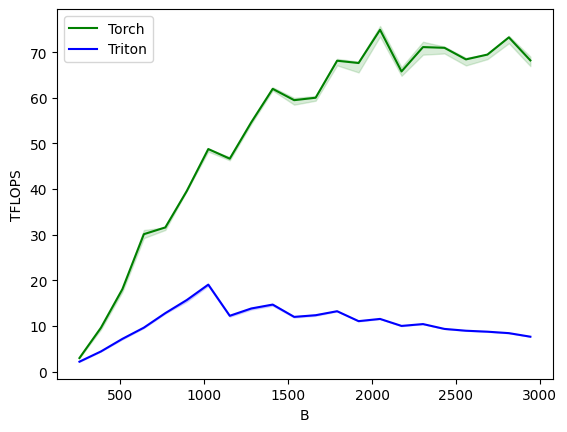

mlp-performance:
         B       D       E      Torch     Triton
0    256.0   256.0   256.0   2.978909   2.184533
1    384.0   384.0   384.0   9.616695   4.423680
2    512.0   512.0   512.0  18.078896   7.182027
3    640.0   640.0   640.0  30.117647   9.637647
4    768.0   768.0   768.0  31.597714  12.822261
5    896.0   896.0   896.0  39.575435  15.697520
6   1024.0  1024.0  1024.0  48.770977  19.065018
7   1152.0  1152.0  1152.0  46.656000  12.237640
8   1280.0  1280.0  1280.0  54.613331  13.837837
9   1408.0  1408.0  1408.0  61.952000  14.694814
10  1536.0  1536.0  1536.0  59.478052  11.998327
11  1664.0  1664.0  1664.0  60.011502  12.362469
12  1792.0  1792.0  1792.0  68.117719  13.238426
13  1920.0  1920.0  1920.0  67.614519  11.063626
14  2048.0  2048.0  2048.0  74.898285  11.550579
15  2176.0  2176.0  2176.0  65.770274  10.019242
16  2304.0  2304.0  2304.0  71.104774  10.423419
17  2432.0  2432.0  2432.0  70.945618   9.363066
18  2560.0  2560.0  2560.0  68.409184   8.965425
19 

In [13]:
benchmark.run(show_plots=True, print_data=True)
